In [2]:
import numpy as np
import pandas as pd
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

read LA dataset

In [3]:
BASE_PATH = 'asvpoof-2019-dataset/LA/LA'
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
SAMPLE_RATE = 16000
DURATION = 5.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

### Train dataset

In [4]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.head(5)

,0,1,2,3,4
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [5]:
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df.head(5)

,speaker_id,filename,system_id,class_name
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


In [6]:
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32')
# train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print('len Train', len(train_df))
train_df.head(5)

len Train 25380


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
1,LA_0079,LA_T_1271820,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
2,LA_0079,LA_T_1272637,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
3,LA_0079,LA_T_1276960,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
4,LA_0079,LA_T_1341447,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0


In [7]:
train_df['target'].value_counts()

1    22800
0     2580
Name: target, dtype: int64

In [8]:
neg, pos = np.bincount(train_df['target'])
print(f'positive count:{pos} negative count:{neg}')
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


pos_wt = train_df.shape[0]/(2*pos)
neg_wt = train_df.shape[0]/(2*neg)
class_weight = {1:pos_wt,0:neg_wt}
print(class_weight)

positive count:22800 negative count:2580
Examples:
    Total: 25380
    Positive: 22800 (89.83% of total)

{1: 0.5565789473684211, 0: 4.9186046511627906}


### Eval
While the **training** and **development** sets contain spoofing attacks generated with the same algorithms/conditions (designated as *known attacks*)

In [9]:
eval_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt',
                       sep=" ", header=None)
eval_df.head(2)

,0,1,2,3,4
0,LA_0069,LA_D_1047731,-,-,bonafide
1,LA_0069,LA_D_1105538,-,-,bonafide


In [10]:
eval_df.columns =['speaker_id','filename','system_id','null','class_name']
eval_df.drop(columns=['null'],inplace=True)
eval_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+eval_df.filename+'.flac'
eval_df['target'] = (eval_df.class_name=='spoof').astype('int32')
# eval_df = eval_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Len Eval: {len(eval_df)}')
eval_df.head(2)

Len Eval: 24844


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev...,0
1,LA_0069,LA_D_1105538,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev...,0


### Test
The **evaluation** set also contains attacks generated with different algorithms/conditions (designated as *unknown* attacks)

In [11]:
test_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt',
                       sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_eval/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
# test_df = test_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Len Test: {len(test_df)}')
test_df.head(2)

Len Test: 71237


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0039,LA_E_2834763,-,spoof,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eva...,1
1,LA_0014,LA_E_8877452,-,spoof,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eva...,1


In [12]:
def load_audio(filepath, sr=16000):
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio, axis='time', sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))
    
def plot_spectrum(audio, sr=16000):
    # Perform FFT to convert the audio signal to the frequency domain
    spectrum = np.fft.fft(audio)
    frequencies = np.fft.fftfreq(len(spectrum), d=1/sr)

    # Plot the spectrum
    # Plot the spectrum for positive frequencies only
    positive_freq_mask = frequencies >= 0
    plt.plot(frequencies[positive_freq_mask], np.abs(spectrum[positive_freq_mask]))
    plt.title('Spectrum of Original Audio Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.show()


def get_spec(audio):
    spec = librosa.feature.melspectrogram(y=audio, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000):
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='hz', hop_length=HOP_LEN, sr=SAMPLE_RATE, fmax=FMAX,)
    return fig

### Before clean noise

> Filename: LA_T_8458654 | Label: bonafide
# Listen


# Plot



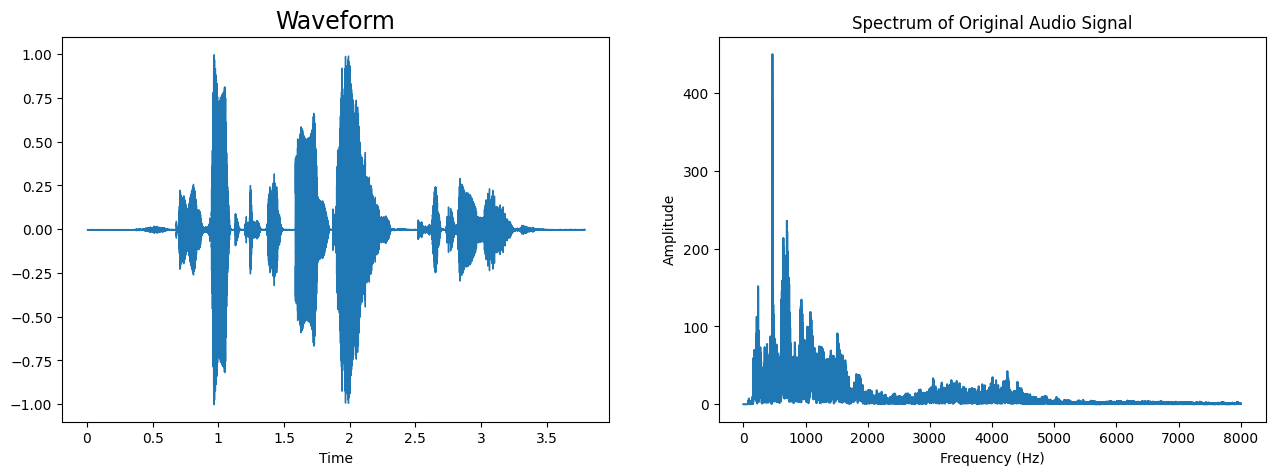

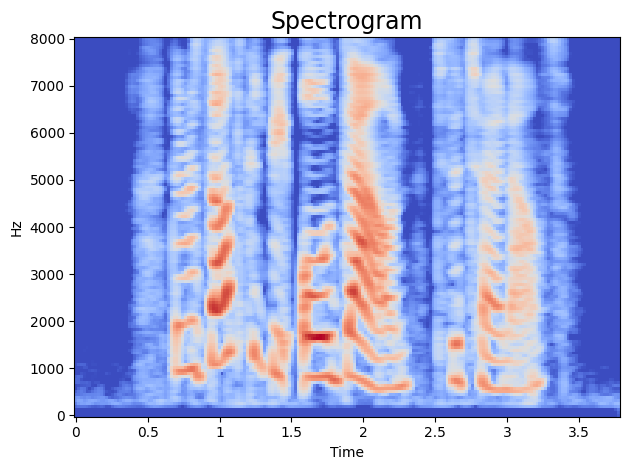

In [19]:
row = train_df[train_df.target==0].iloc[100]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(131)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(132)
plot_spectrum(audio)

# plt.subplot(133)
plot_spec(spec)
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

### After clean noise

In [14]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

> Filename: LA_T_8458654 | Label: bonafide
# Listen


# Plot



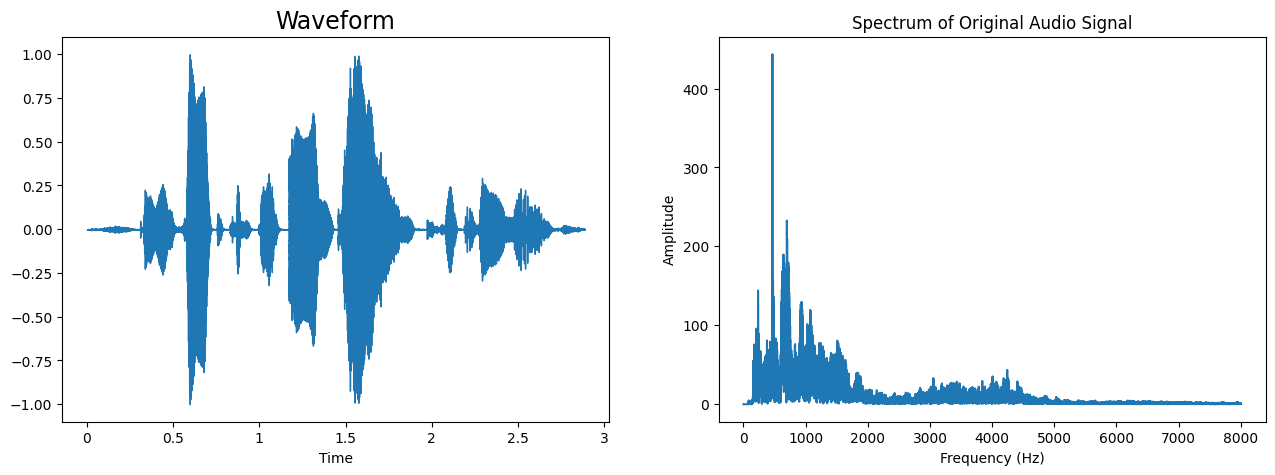

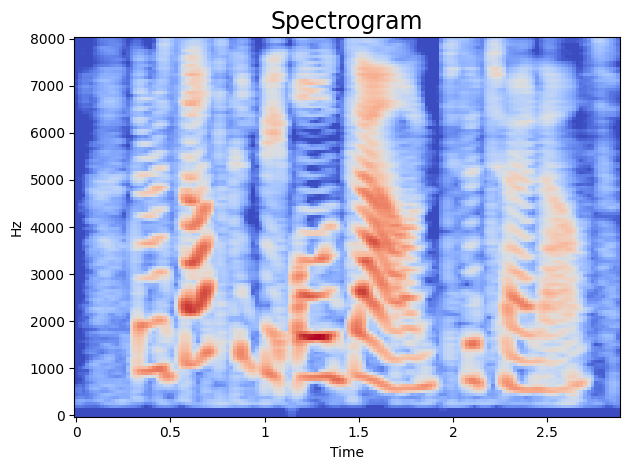

In [18]:
row = train_df[train_df.target==0].iloc[100]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
mask, _ = envelope(audio, sr, 0.004)  # can adjust the threshold
audio = audio[mask]

audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(131)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(132)
plot_spectrum(audio)

# plt.subplot(133)
plot_spec(spec)
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

此範例是使用已設計好的"facebook/wav2vec2-base" model  
接下來要查如何用圖片做機器學習

存train data的spectrogram到spectrogram_images_train folder中

In [24]:
len(train_df) // 3

8460

先存一半，以免當掉

In [21]:
train_df_first = train_df[0:len(train_df) // 3]
train_df_second = train_df[len(train_df) // 3 : 2 * len(train_df) // 3]
train_df_third = train_df[2 * len(train_df) // 3 :]


In [22]:
import os

# Create a directory to store the spectrogram images
output_folder = "clean_spectrogram_images_train"

os.makedirs(output_folder, exist_ok=True)

# Iterate through each row in the DataFrame
for index, row in train_df_first.iterrows():
    audio, sr = load_audio(row["filepath"], sr=None)
    # delete the noise
    mask, _ = envelope(audio, sr, 0.005)  # can adjust the threshold
    audio = audio[mask]
    audio = audio[:AUDIO_LEN]
    spec = get_spec(audio)

    fig = plot_spec(spec)
    plt.title("Spectrogram", fontsize=17)

    # Save the spectrogram image with a meaningful filename
    filename = f"spec_{row['filename']}.png"  # Use single quotes inside the f-string
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath)

    # Close the figure to free up resources
    plt.close()

print(f"Spectrogram images saved to {output_folder}")


Spectrogram images saved to clean_spectrogram_images_train


In [23]:
import os

# Create a directory to store the spectrogram images
output_folder = "clean_spectrogram_images_train"

os.makedirs(output_folder, exist_ok=True)

# Iterate through each row in the DataFrame
for index, row in train_df_second.iterrows():
    audio, sr = load_audio(row["filepath"], sr=None)
    # delete the noise
    mask, _ = envelope(audio, sr, 0.005)  # can adjust the threshold
    audio = audio[mask]
    audio = audio[:AUDIO_LEN]
    spec = get_spec(audio)

    fig = plot_spec(spec)
    plt.title("Spectrogram", fontsize=17)

    # Save the spectrogram image with a meaningful filename
    filename = f"spec_{row['filename']}.png"  # Use single quotes inside the f-string
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath)

    # Close the figure to free up resources
    plt.close()

print(f"Spectrogram images saved to {output_folder}")


Spectrogram images saved to clean_spectrogram_images_train


In [25]:
import os

# Create a directory to store the spectrogram images
output_folder = "clean_spectrogram_images_train"

os.makedirs(output_folder, exist_ok=True)

# Iterate through each row in the DataFrame
for index, row in train_df_third.iterrows():
    audio, sr = load_audio(row["filepath"], sr=None)
    # delete the noise
    mask, _ = envelope(audio, sr, 0.005)  # can adjust the threshold
    audio = audio[mask]
    audio = audio[:AUDIO_LEN]
    spec = get_spec(audio)

    fig = plot_spec(spec)
    plt.title("Spectrogram", fontsize=17)

    # Save the spectrogram image with a meaningful filename
    filename = f"spec_{row['filename']}.png"  # Use single quotes inside the f-string
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath)

    # Close the figure to free up resources
    plt.close()

print(f"Spectrogram images saved to {output_folder}")


Spectrogram images saved to clean_spectrogram_images_train
